In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

seaborn 0.10.1
numpy   1.18.4
pandas  1.0.4



In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
import shap

import pandas as pd
import requests

from io import StringIO

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [3]:
from collections import defaultdict
from glob import glob

url = requests.get('https://docs.google.com/spreadsheets/d/1xqhFLsQplNUu5k9Uxv7DgTwftCiE78E0JmsKvNi0Ft4/export?format=csv')
csv_raw = StringIO(url.text)
df_truth = pd.read_csv(csv_raw)

inf_tax_file = "/mnt/btrfs/data/rep202/ab/taxmap.tsv"

In [4]:
dd = defaultdict(set)
dd_species = defaultdict(set)
for t in df_truth.itertuples():
    query = t.homotypic_synonym
    results = !rg {query} {inf_tax_file}
    if len(results) > 0:
        for r in results:
            split = r.split("\t")
            dd[t.dataset].add(split[0])
            dd_species[t.dataset].add(";".join(split[1].split(";")[:7]))

In [5]:
df_tax = pd.read_csv(inf_tax_file, names=["assembly_accession", "tax"], sep="\t")

df_tax["species"] = [";".join(_.split(";")[:7]) for _ in df_tax.tax]
df_tax["genus"] = [";".join(_.split(";")[:6]) for _ in df_tax.tax]
df_tax["family"] = [";".join(_.split(";")[:5]) for _ in df_tax.tax]

In [6]:
from glob import glob
import os

basepath = "/mnt/btrfs/data/type_1/species_mc"
dirs = [d for d in os.listdir(basepath) if os.path.isdir(os.path.join(basepath, d))]

# dual_index failed
dirs.remove('dual_index')

In [7]:
dfs = []
for directory in dirs:
    df = pd.read_csv(os.path.join(basepath, directory, 'filter', 't1.coverage.r202.txt'), index_col = 0)
    df['dataset'] = directory
    dfs.append(df)
    
df_type_1_features = pd.concat(dfs)

In [8]:
dfs = []
for directory in dirs:
    df = pd.read_csv(os.path.join(basepath, directory, 'filter', 'shogun.capitalist.r202.txt'), index_col = None, sep="\t")
    cols = list(df.columns)
    cols[0] = "tax"
    cols[1] = "hits"
    df.columns = cols

    df = df.loc[:, df.columns.difference(cols[2:])]
    df["dataset"] = directory
    df["relative_abundace"] = df.hits / df.hits.sum()
    dfs.append(df)    
df_capitalist_species = pd.concat(dfs)
df_capitalist_species["species"] = [";".join(_.split(";")[:7]) for _ in df_capitalist_species.tax]

In [9]:
rows = []
for t in df_type_1_features.itertuples():
    if t.assembly_accession in dd[t.dataset]:
        rows.append(True)
    else:
        rows.append(False)
df_type_1_features["truth"] = rows

In [10]:
rows = []
for t in df_capitalist_species.itertuples():
    if t.species in dd_species[t.dataset]:
        rows.append(True)
    else:
        rows.append(False)
df_capitalist_species["truth"] = rows

In [11]:
ra_mask = df_capitalist_species["relative_abundace"] > .005

basepath_sim = "/mnt/btrfs/data/type_1/simulation_strain/sims"
db_features = "/mnt/nvidia/pkr/code/type_1/data/db_features.csv"

df_c_ra = df_capitalist_species[ra_mask]

strain_probas = []

for dataset in ["zymo", "mbarc", "hmp", "gis"]:
    
    X_type_1 = df_type_1_features.loc[:, df_type_1_features.columns.difference(["shannon_entropy"])]
                                                 
    X_type_1 = X_type_1.replace([np.inf, -np.inf], np.nan)
    X_type_1 = X_type_1.dropna()
    
    mask_dataset = np.array([_.startswith(dataset) for _ in X_type_1["dataset"]])

    y = X_type_1["truth"]
    X_type_1 = X_type_1.loc[:, X_type_1.columns.difference(["assembly_accession", "dataset", "truth"])]
    
    X_type_1_train = X_type_1.loc[~mask_dataset, :]
    X_type_1_test =  X_type_1.loc[mask_dataset, :]
    y_train = y.loc[~mask_dataset]
    y_test = y.loc[mask_dataset]
    
    clf = RandomForestClassifier(random_state=42)

    clf.fit(X_type_1_train, y_train)
    
    text_files = glob(f"{basepath_sim}/*{dataset}*.txt", recursive=True)
    dfs = []
    for file in text_files:
        dfs.append(pd.read_csv(file, index_col = 0))
    df_orig_strain = pd.concat(dfs)

    df_strain = df_orig_strain.loc[:, df_orig_strain.columns.difference(["assembly_accession", "shannon_entropy"])]
    probas = clf.predict_proba(df_strain)

    df_strain["proba"] = probas[:,1]
    df_strain["dataset"] = dataset
    df_strain["assembly_accession"] = df_orig_strain["assembly_accession"]
    df_strain["shannon_entropy"] = df_orig_strain["shannon_entropy"]
    
    strain_probas.append(df_strain)

In [12]:
df_strains = pd.concat(strain_probas)

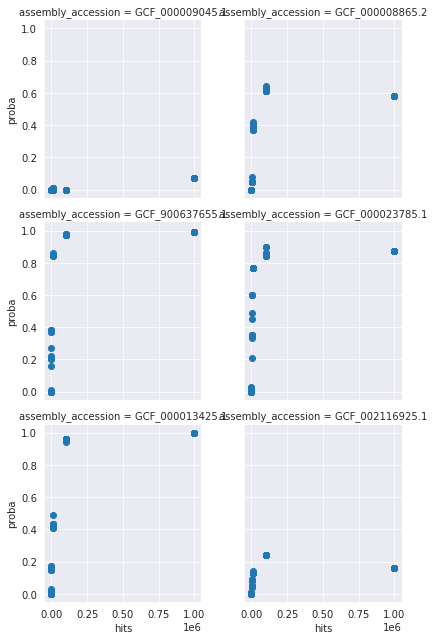

In [13]:
df_strains.sort_values("hits", inplace=True)
g = sns.FacetGrid(df_strains, col="assembly_accession", col_wrap=2)
g.map(plt.scatter, "hits", "proba")
plt.show()

In [14]:
df_strains[df_strains.percent_coverage > 1.0].percent_coverage.max()

50401940589.40969

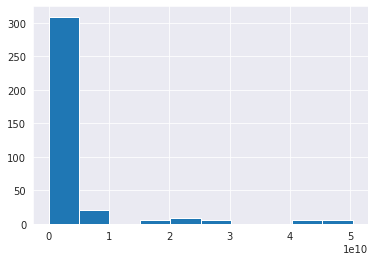

In [15]:
df_strains["percent_coverage"].hist()

In [16]:
df_strains["percent_coverage"].max()

50401940589.40969

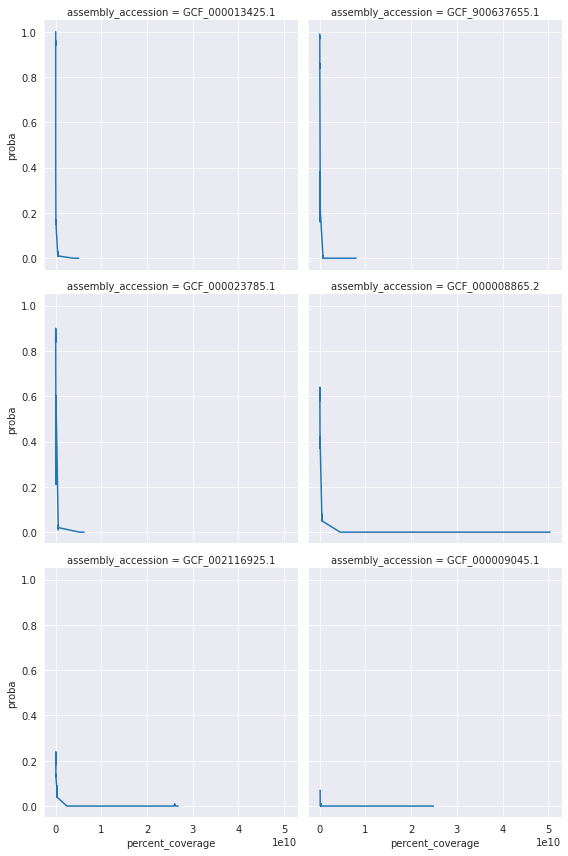

In [17]:
df_strains.sort_values("percent_coverage", inplace=True)
g = sns.FacetGrid(df_strains, col="assembly_accession", col_wrap=2, height=4)
g.map(sns.lineplot, "percent_coverage", "proba")
plt.show()